# COVID-19 ICU Patient Analysis

In this notebook, we perform an exploratory data analysis (EDA) of ICU patients diagnosed with COVID-19 using the MIMIC database. Our objectives are to understand the characteristics, outcomes, and treatment patterns of COVID-19 patients in the ICU setting. 

Specifically, we aim to:
- Isolate COVID-19 patients based on ICD codes.
- Analyze trends in ICU admissions over time.
- Investigate mortality rates among COVID-19 patients by age group, year group, and insurance type.
- Compare demographics and outcomes between COVID-19 and non-COVID-19 ICU patients.
- Explore prescription patterns, focusing on antiviral medications prescribed to COVID-19 patients.
- Compare patient data with external datasets, such as Medicare beneficiaries in Suffolk County.

## Intro

Overview of objectives and dataset description

## Data Loading and Preprocessing

### Imports and Configurations

In [14]:
# for developmental purposes
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
# Data manipulation and visualization libraries
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# Import the Preprocessor class and Utility functions
from config import FILE_PATHS
from preprocessing.preprocessor import Preprocessor
from preprocessing.utils import Utils

# for interactive displays
from preprocessing.utils import Utils

# Initialize the preprocessor class
preprocessor = Preprocessor(file_paths=FILE_PATHS)

#### Data Loading

Load patient, admissions, ICU stays, and prescription data from Processed Data Folder

In [40]:
patients_df = pd.read_pickle('../Processed_Data/patients.pkl')
admission_df = pd.read_pickle('../Processed_Data/admissions.pkl')
icu_stays_df = pd.read_pickle('../Processed_Data/icu_stays.pkl')


Utils.display_dataframes([patients_df, admission_df, icu_stays_df], ['Patients', 'Admissions', 'ICU Stays'])

Let's load thte processed hospital diagnosis table, which has linked all ICD codes to their corresponding disease cateogries and subcategories.

This will allow us to perform a more detailed analysis of the COVID-19 diagnoses and their impact on patient outcomes.

In [50]:
hosp_diagnosis_cause_df = pd.read_pickle("../Processed_Data/hosp_diagnosis.pkl")
# lets take a look at a sample of the data
hosp_diagnosis_cause_df.sample(5, random_state=42)

,subject_id,hadm_id,icd_code,icd_version,category_code,category,subcategory
2727769,19390719,29701453,4019,9,401,Circulatory System,Hypertensive Disease
4813771,15493609,27397414,Y92230,10,Y92,External Causes,Supplementary factors related to causes of mor...
1509173,15200895,24824236,44024,9,440,Circulatory System,"Diseases Of Arteries, Arterioles, And Capillaries"
1385006,14786669,24737993,V1251,9,V12,Other,Other
5236415,16711794,27107405,Z950,10,Z95,Other,Other


### Data Preprocessing

Clean and merge the datasets for analysis

In [54]:
# merge on subject_id and hadm_id
diagnosis_icu_df = hosp_diagnosis_cause_df.merge(icu_stays_df, on=['subject_id', 'hadm_id'], how='inner')
# merge with patients table to get demographics
diagnosis_icu_df = diagnosis_icu_df.merge(patients_df, on='subject_id', how='inner')
# merge with admission for insurance data
diagnosis_icu_df = diagnosis_icu_df.merge(admission_df.drop('is_dead', axis=1), on=['subject_id', 'hadm_id'], how='inner')

# save to pickle file
diagnosis_icu_df.to_pickle("../Processed_Data/diagnosis_icu_df.pkl")

diagnosis_icu_df.head(3)

,subject_id,hadm_id,icd_code,icd_version,category_code,category,subcategory,stay_id,first_careunit,last_careunit,...,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag,admission_los_hours
0,10000032,29079034,45829,9,458,Circulatory System,"Diseases Of Veins And Lymphatics, And Other Di...",39553978,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),...,EMERGENCY ROOM,HOME,Medicaid,English,WIDOWED,White/European Descent,2180-07-23 05:54:00,2180-07-23 14:00:00,0,53.333333
1,10000032,29079034,07044,9,070,Other,Other,39553978,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),...,EMERGENCY ROOM,HOME,Medicaid,English,WIDOWED,White/European Descent,2180-07-23 05:54:00,2180-07-23 14:00:00,0,53.333333
2,10000032,29079034,7994,9,799,Symptoms & Abnormal Findings,Ill-Defined And Unknown Causes Of Morbidity An...,39553978,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),...,EMERGENCY ROOM,HOME,Medicaid,English,WIDOWED,White/European Descent,2180-07-23 05:54:00,2180-07-23 14:00:00,0,53.333333


## Exploratory Analysis of ICU Admissions 

### Exploring Overall ICU Patients

Lets get an idea of the ICU patient population from the years 2008 to 2019. We aim to analyze demographics and admission data of ICU patients

In [ ]:
# ...

### Exploring the Disease distribution in the ICU

#### Frequency of Respiratory Diseases

/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_13222/1588128893.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  respiratory_counts = respiratory_df.groupby('anchor_year_group').size()


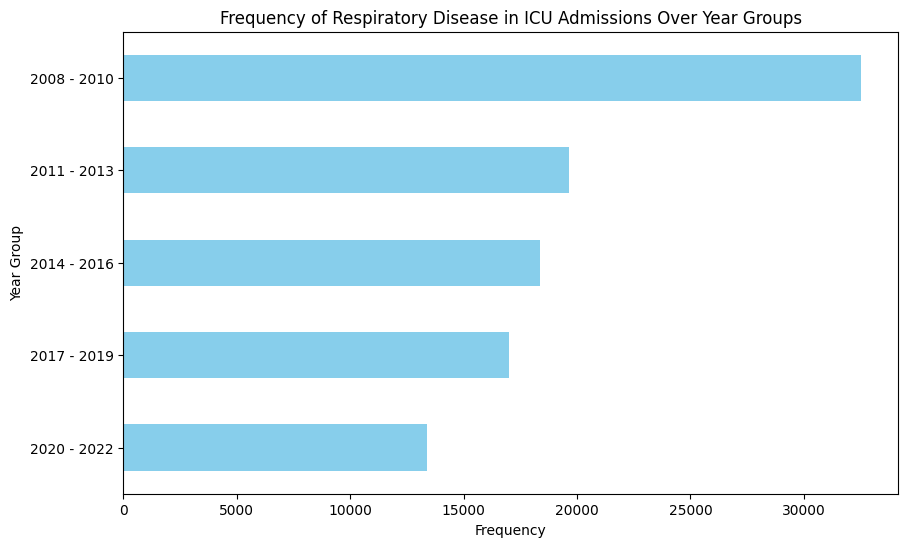

In [12]:
# Filter the dataframe for respiratory disease
respiratory_df = diagnosis_icu_df[diagnosis_icu_df['category'] == 'Respiratory System']

# Group by anchor_year_group and count occurrences
respiratory_counts = respiratory_df.groupby('anchor_year_group').size()

# Plotting
plt.figure(figsize=(10, 6))
respiratory_counts.sort_values().plot(kind='barh', color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Year Group')
plt.title('Frequency of Respiratory Disease in ICU Admissions Over Year Groups')
plt.show()

## Isolating Covid-19 Patients

Isolating COVID-19 patients by icd code

Confirmed—A confirmed COVID-19 hospital encounter is defined as any listed ICD–10–CM diagnosis code of B97.29 and/or U07.1. Prior to April 1, 2020, CDC guidance stated to code a confirmed COVID-19 hospital encounter as B97.29. On April 1, 2020, the guidance changed to code confirmed COVID-19 hospital encounters as U07.1. The figure shows the percentage of hospital encounters coded with a B97.29 and/or U07.1 code. 

Suspected—A suspected COVID-19 hospital encounter in 2020 is defined by an ICD–10–CM code of contact with and (suspected) exposure to other viral communicable diseases (Z20.828) and in 2021 it is defined by an ICD-10-CM code of contact with and (suspected) exposure to COVID-19 (Z20.822). Additionally, suspected encounters do not contain any confirmed codes. In early versions (March 18, 2020 – December 29, 2020) of this figure, suspected COVID-19 was defined by the ICD-10-CM code for COVID-19, virus not identified (U07.2) or coronavirus infection, unspecified (B34.2). Also, the earlier version included potential COVID-19 hospital encounters as having an ICD–10–CM code for pneumonia (J12.89), acute bronchitis (J20.8, J40), lower respiratory infection (J22, J98.8), or Acute Respiratory Distress Syndrome (J80). The potential portion of the definition was removed for this update due to revised CDC guidance for coding suspected COVID-19. See the related links below for coding guidelines.

Sources:
https://www.cdc.gov/nchs/covid19/nhcs/hospital-encounters-by-week.htm
https://jamanetwork.com/journals/jama/fullarticle/2774396

#### Defining COVID-10 ICD Codes and Isolating Patients with COVID-19 ICD codes

Identify ICD codes corresponding to confirmed, suspected, and potential COIVD-19 cases

After filter the datasets to focus on covid-19 pateints based on ICD codes

In [57]:
def get_covid_diagnoses(diagnosis_icu_df):
    """
    Isolate and categorize COVID-19 diagnoses from the given ICU diagnosis dataframe.

    Parameters:
    diagnosis_icu_df (pd.DataFrame): DataFrame containing ICU diagnosis data with an 'icd_code' column.

    Returns:
    pd.DataFrame: A DataFrame containing only the COVID-19 related diagnoses with an additional 'covid_category' column.
                  The 'covid_category' column categorizes the diagnoses into 'Confirmed', 'Suspected', 'Potential', and 'Other'.
    """
    # Define COVID-19 related ICD-10-CM codes
    covid_codes = ['U071', 'U072', 'B9729', 'Z20828', 'Z20822', 'J1289', 'J208', 'J40', 'J22', 'J988', 'J80']

    # Create a regex pattern to match the codes at the start of the string
    covid_pattern = '^(' + '|'.join(covid_codes) + ')'

    # Filter the dataframe for COVID-19 diagnoses using the defined codes with contains
    covid_diagnoses = diagnosis_icu_df[diagnosis_icu_df['icd_code'].str.contains(covid_pattern, regex=True, na=False)].copy()

    # Create a new column to categorize the diagnosis
    covid_diagnoses.loc[:, 'covid_category'] = 'Other'
    covid_diagnoses.loc[covid_diagnoses['icd_code'].str.contains('^(U071|U072|B9729)', regex=True, na=False), 'covid_category'] = 'Confirmed'
    covid_diagnoses.loc[covid_diagnoses['icd_code'].str.contains('^(Z20828|Z20822)', regex=True, na=False), 'covid_category'] = 'Suspected'
    covid_diagnoses.loc[covid_diagnoses['icd_code'].str.contains('^(J1289|J208|J40|J22|J988|J80)', regex=True, na=False), 'covid_category'] = 'Potential'
    
    return covid_diagnoses

covid_diagnoses = get_covid_diagnoses(diagnosis_icu_df)

/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_13222/828384420.py:9: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  covid_diagnoses = diagnosis_icu_df[diagnosis_icu_df['icd_code'].str.contains(covid_pattern, regex=True, na=False)].copy()
/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_13222/828384420.py:13: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  covid_diagnoses.loc[covid_diagnoses['icd_code'].str.contains('^(U071|U072|B9729)', regex=True, na=False), 'covid_category'] = 'Confirmed'
/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_13222/828384420.py:14: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  covid_diagnoses.loc[covid_diagnoses['icd_code'].str.contains('^(Z20828|Z20822)', regex=Tru

#### Trend Analysis 
 
Lets Analyze the number of admissions with COVID-19 ICD codes

/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_13222/2242869873.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  covid_counts = covid_diagnoses.groupby(['anchor_year_group', 'covid_category']).size().unstack(fill_value=0)


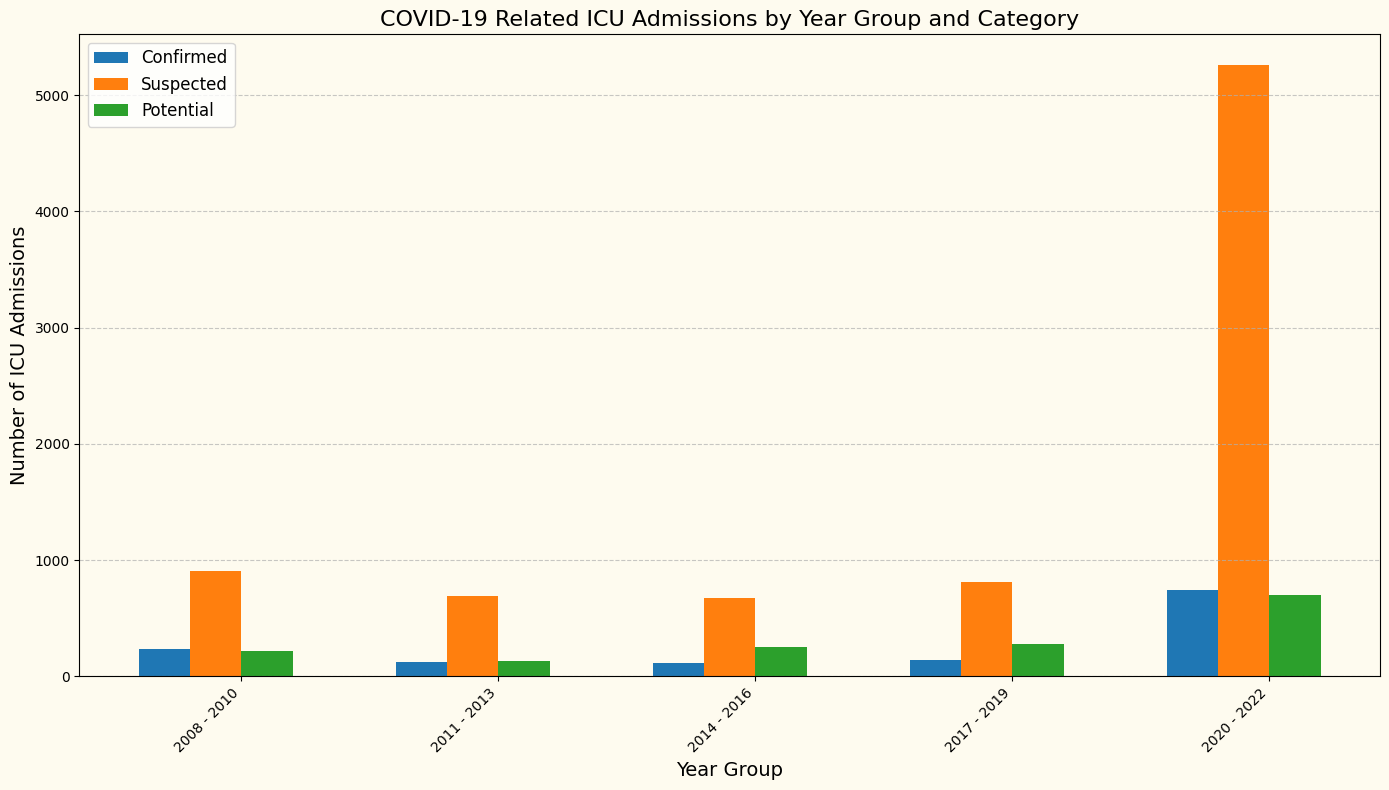

In [63]:
def plot_covid_admissions_by_year_group(covid_diagnoses):
    """
    Plot the number of COVID-19 related ICU admissions by year group and category.

    Parameters:
    covid_diagnoses (pd.DataFrame): DataFrame containing COVID-19 related diagnoses with 'anchor_year_group' and 'covid_category' columns.
    """
    # Group by anchor_year_group and covid_category, then count occurrences
    covid_counts = covid_diagnoses.groupby(['anchor_year_group', 'covid_category']).size().unstack(fill_value=0)

    # Sort the year groups in chronological order
    covid_counts = covid_counts.sort_index(key=lambda x: x.str.split(' - ').str[0].astype(int))

    # Plotting
    plt.figure(figsize=(14, 8), facecolor='#fefbef')
    ax = plt.gca()
    ax.set_facecolor('#fefbef')
    bar_width = 0.2
    index = np.arange(len(covid_counts.index))

    for i, category in enumerate(['Confirmed', 'Suspected', 'Potential']):
        if category in covid_counts.columns:
            plt.bar(index + i*bar_width, covid_counts[category], bar_width, label=category)

    plt.xlabel('Year Group', fontsize=14)
    plt.ylabel('Number of ICU Admissions', fontsize=14)
    plt.title('COVID-19 Related ICU Admissions by Year Group and Category', fontsize=16)
    plt.xticks(index + bar_width * 1.5, covid_counts.index, rotation=45, ha='right')
    plt.legend(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()


plot_covid_admissions_by_year_group(covid_diagnoses)

## Mortality Analysis Among COVID-19 Patients

#### Overall Mortality Rates

- Calculate mortality rates for COVID-19 patients across year groups

/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_13222/2279512239.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mortality_data = covid_diagnoses.groupby('anchor_year_group').agg({


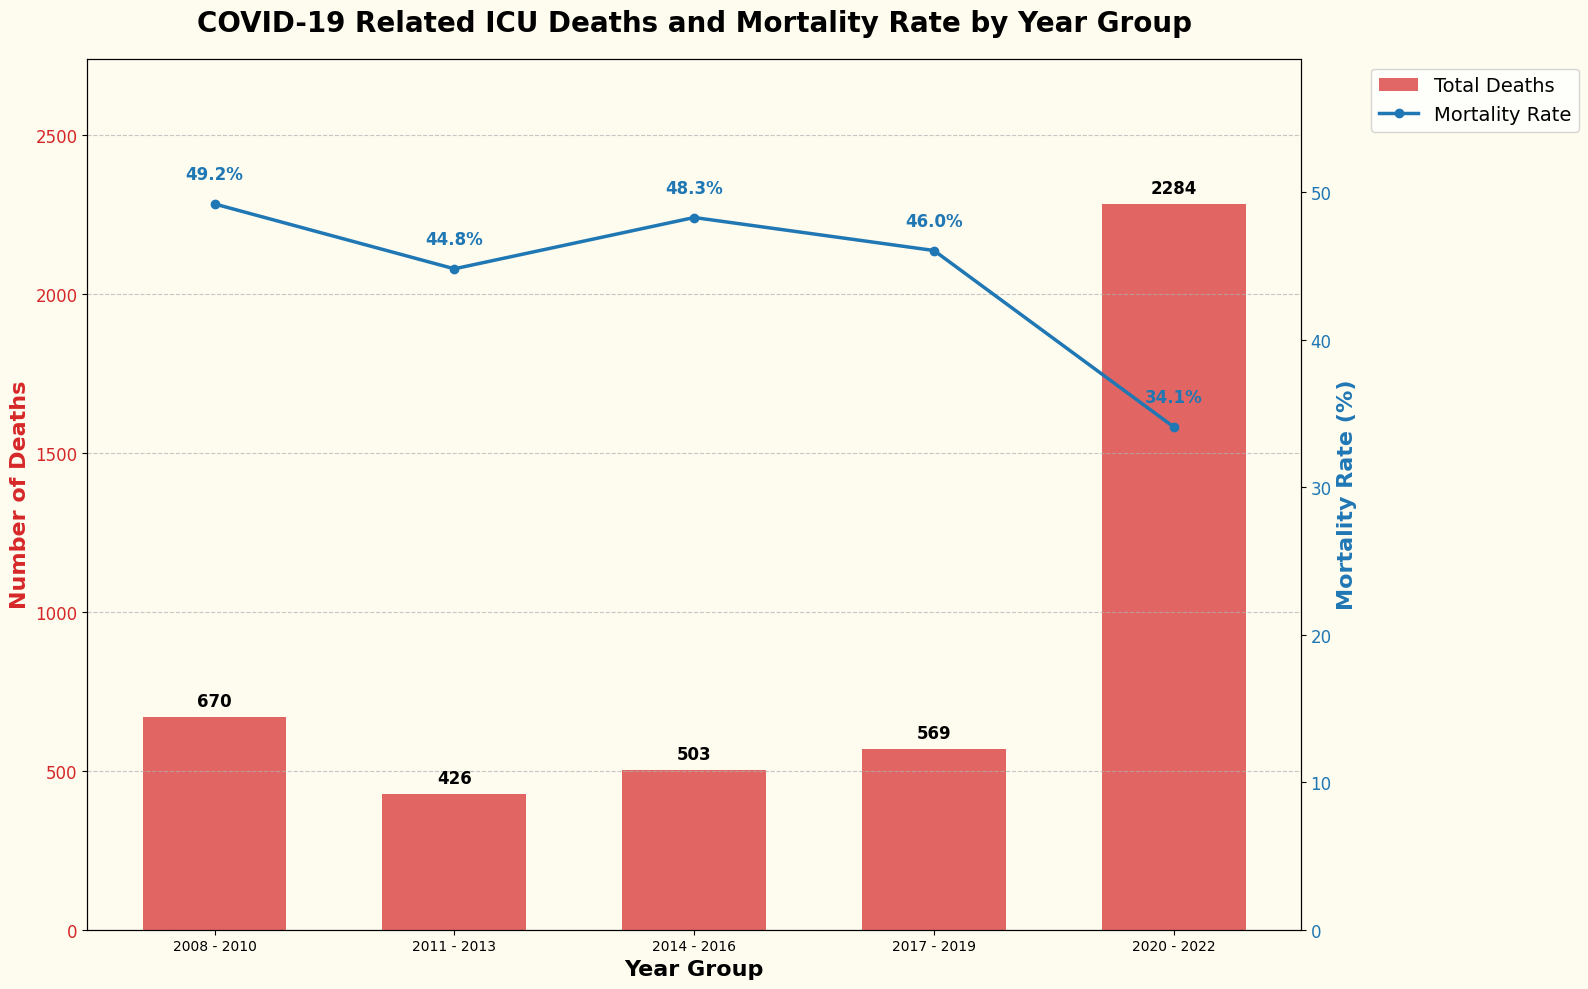

In [62]:
def plot_mortality_by_year_group(covid_diagnoses):
    """
    Plot the number of COVID-19 related ICU deaths and mortality rate by year group.

    Parameters:
    covid_diagnoses (pd.DataFrame): DataFrame containing COVID-19 related diagnoses with 'anchor_year_group' and 'is_dead' columns.
    """
    # Group by anchor_year_group and calculate total deaths and mortality rate
    mortality_data = covid_diagnoses.groupby('anchor_year_group').agg({
        'is_dead': ['count', 'sum']
    })

    mortality_data.columns = ['total_patients', 'deaths']
    mortality_data['mortality_rate'] = mortality_data['deaths'] / mortality_data['total_patients'] * 100

    # Sort the year groups in chronological order
    mortality_data = mortality_data.sort_index(key=lambda x: x.str.split(' - ').str[0].astype(int))

    # Plotting
    fig, ax1 = plt.subplots(figsize=(16, 10), facecolor='#fefbef')
    ax1.set_facecolor('#fefbef')

    # Bar plot for total deaths
    bars = ax1.bar(mortality_data.index, mortality_data['deaths'], 
                   alpha=0.7, color='#d62728', label='Total Deaths', width=0.6)
    ax1.set_xlabel('Year Group', fontsize=16, weight='bold')
    ax1.set_ylabel('Number of Deaths', fontsize=16, weight='bold', color='#d62728')
    ax1.tick_params(axis='y', labelcolor='#d62728', labelsize=12)
    ax1.set_ylim(0, mortality_data['deaths'].max() * 1.2)
    ax1.grid(axis='y', linestyle='--', alpha=0.7)

    # Line plot for mortality rate
    ax2 = ax1.twinx()
    line = ax2.plot(mortality_data.index, mortality_data['mortality_rate'], 
                   color='#1f77b4', marker='o', linewidth=2.5, label='Mortality Rate')
    ax2.set_ylabel('Mortality Rate (%)', fontsize=16, weight='bold', color='#1f77b4')
    ax2.tick_params(axis='y', labelcolor='#1f77b4', labelsize=12)
    ax2.set_ylim(0, mortality_data['mortality_rate'].max() * 1.2)

    # Title and legend
    plt.title('COVID-19 Related ICU Deaths and Mortality Rate by Year Group', fontsize=20, weight='bold', pad=20)
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    plt.legend(handles=handles1 + handles2, labels=labels1 + labels2, 
               loc='upper left', fontsize=14, bbox_to_anchor=(1.05, 1))

    # Rotate x-axis labels
    plt.xticks(rotation=45, ha='right', fontsize=12)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax1.annotate(f'{int(height)}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5),  # 5 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=12, fontweight='bold')

    # Add value labels on line plot
    for x, y in zip(mortality_data.index, mortality_data['mortality_rate']):
        ax2.annotate(f'{y:.1f}%',
                    xy=(x, y),
                    xytext=(0, 15),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=12, color='#1f77b4', fontweight='bold')

    plt.tight_layout()
    plt.show()

plot_mortality_by_year_group(covid_diagnoses)

#### Mortality by Age Group

Assess how mortality rates vary by age group for COVID-19 patients

/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_13222/3895406474.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_mortality = covid_diagnoses.groupby('age_group').agg(


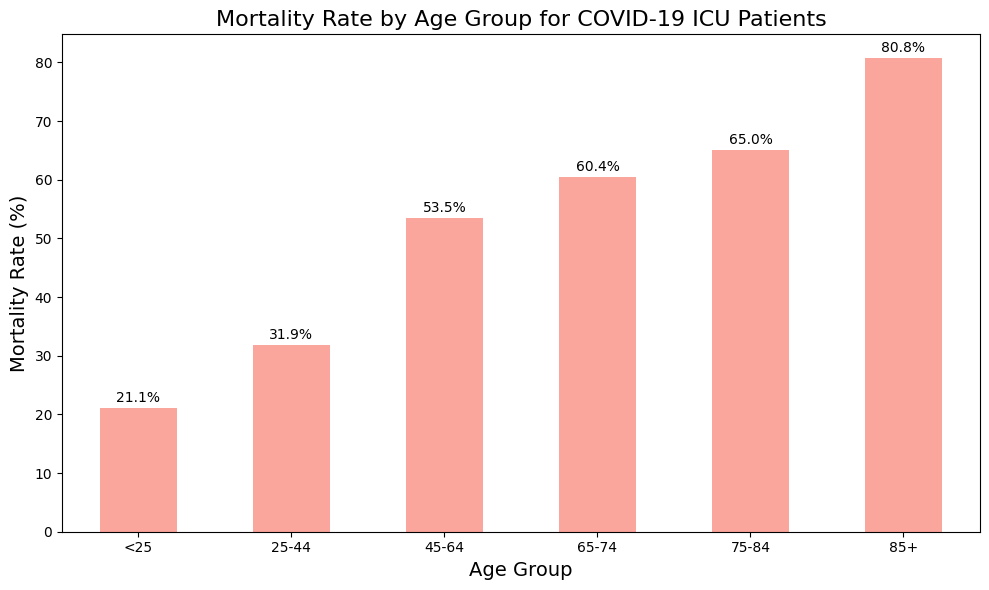

In [64]:
def plot_mortality_by_age_group(covid_diagnoses):
    # Create age groups
    covid_diagnoses['age_group'] = pd.cut(
        covid_diagnoses['anchor_age'],
        bins=[0, 25, 45, 65, 75, 85, 100],
        labels=['<25', '25-44', '45-64', '65-74', '75-84', '85+']
    )

    # Calculate mortality rate by age group
    age_mortality = covid_diagnoses.groupby('age_group').agg(
        total_patients=('subject_id', 'nunique'),
        deaths=('is_dead', 'sum')
    )
    age_mortality['mortality_rate'] = age_mortality['deaths'] / age_mortality['total_patients'] * 100

    # Plotting
    plt.figure(figsize=(10, 6))
    age_mortality['mortality_rate'].plot(kind='bar', color='salmon', alpha=0.7)
    plt.title('Mortality Rate by Age Group for COVID-19 ICU Patients', fontsize=16)
    plt.xlabel('Age Group', fontsize=14)
    plt.ylabel('Mortality Rate (%)', fontsize=14)
    plt.xticks(rotation=0)

    # Add value labels on top of bars
    for index, value in enumerate(age_mortality['mortality_rate']):
        plt.text(index, value + 0.5, f'{value:.1f}%', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

plot_mortality_by_age_group(covid_diagnoses)

/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_1828/753888253.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  time_mortality = covid_diagnoses.groupby('anchor_year_group').agg(


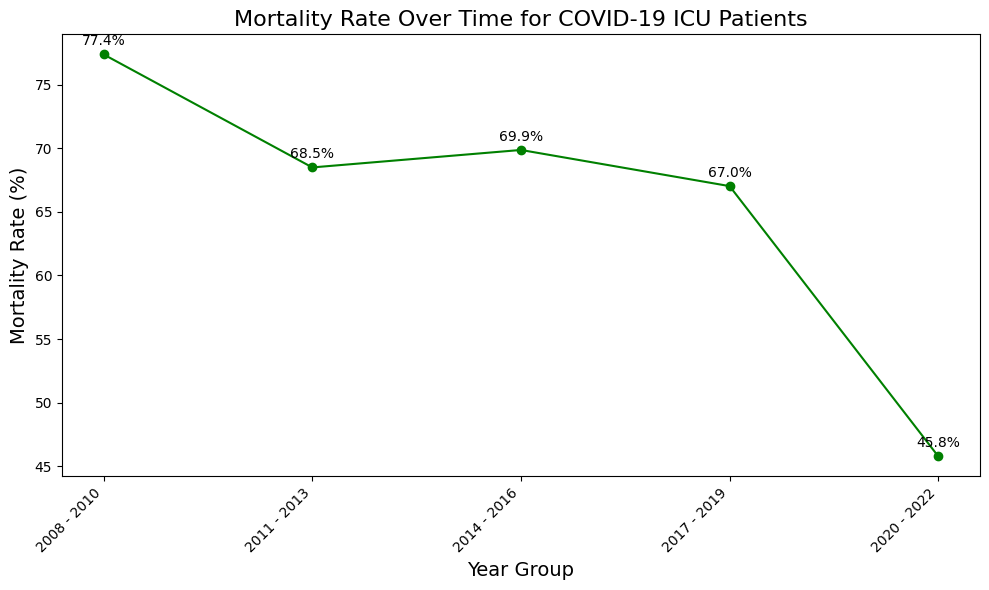

In [28]:
# Calculate mortality rate by year group
time_mortality = covid_diagnoses.groupby('anchor_year_group').agg(
    total_patients=('subject_id', 'nunique'),
    deaths=('is_dead', 'sum')
)
time_mortality['mortality_rate'] = time_mortality['deaths'] / time_mortality['total_patients'] * 100

# Sort the year groups chronologically
time_mortality = time_mortality.sort_index(key=lambda x: x.str.split(' - ').str[0].astype(int))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(time_mortality.index, time_mortality['mortality_rate'], marker='o', linestyle='-', color='green')
plt.title('Mortality Rate Over Time for COVID-19 ICU Patients', fontsize=16)
plt.xlabel('Year Group', fontsize=14)
plt.ylabel('Mortality Rate (%)', fontsize=14)
plt.xticks(rotation=45, ha='right')

# Add data labels
for x, y in zip(time_mortality.index, time_mortality['mortality_rate']):
    plt.text(x, y + 0.5, f'{y:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_1828/2039472151.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  insurance_mortality = covid_diagnoses.groupby('insurance').agg(


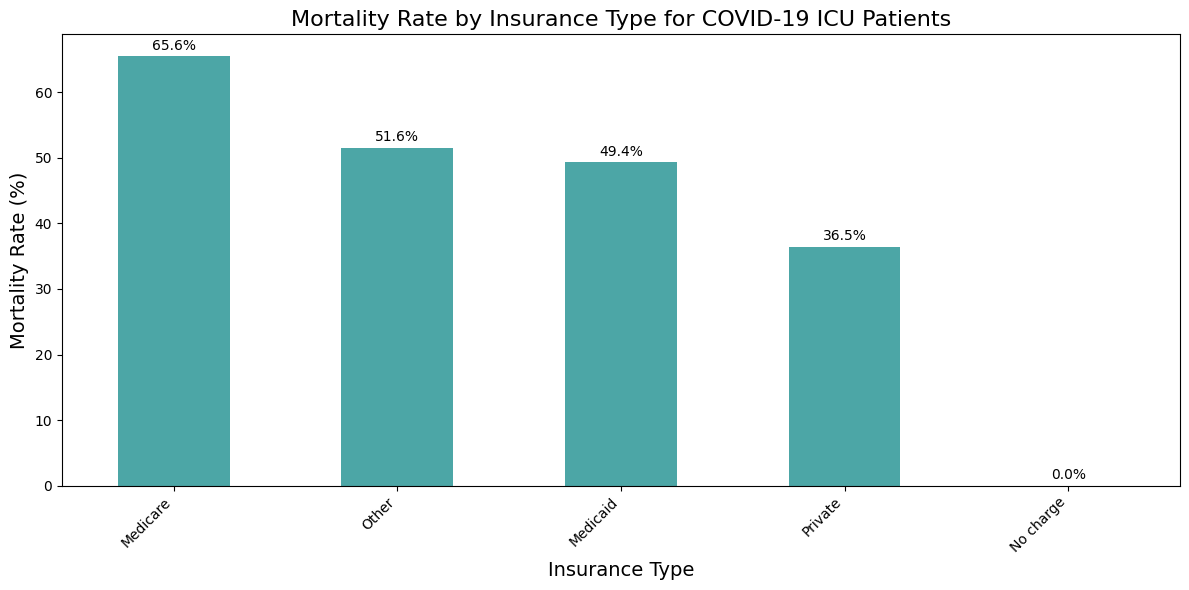

In [29]:
# Calculate mortality rate by insurance type
insurance_mortality = covid_diagnoses.groupby('insurance').agg(
    total_patients=('subject_id', 'nunique'),
    deaths=('is_dead', 'sum')
)
insurance_mortality['mortality_rate'] = insurance_mortality['deaths'] / insurance_mortality['total_patients'] * 100

# Sort by mortality rate
insurance_mortality = insurance_mortality.sort_values(by='mortality_rate', ascending=False)

# Plotting
plt.figure(figsize=(12, 6))
insurance_mortality['mortality_rate'].plot(kind='bar', color='teal', alpha=0.7)
plt.title('Mortality Rate by Insurance Type for COVID-19 ICU Patients', fontsize=16)
plt.xlabel('Insurance Type', fontsize=14)
plt.ylabel('Mortality Rate (%)', fontsize=14)
plt.xticks(rotation=45, ha='right')

# Add value labels
for index, value in enumerate(insurance_mortality['mortality_rate']):
    plt.text(index, value + 0.5, f'{value:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_1828/1180802082.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = covid_diagnoses.groupby(['anchor_year_group', 'age_group']).agg(


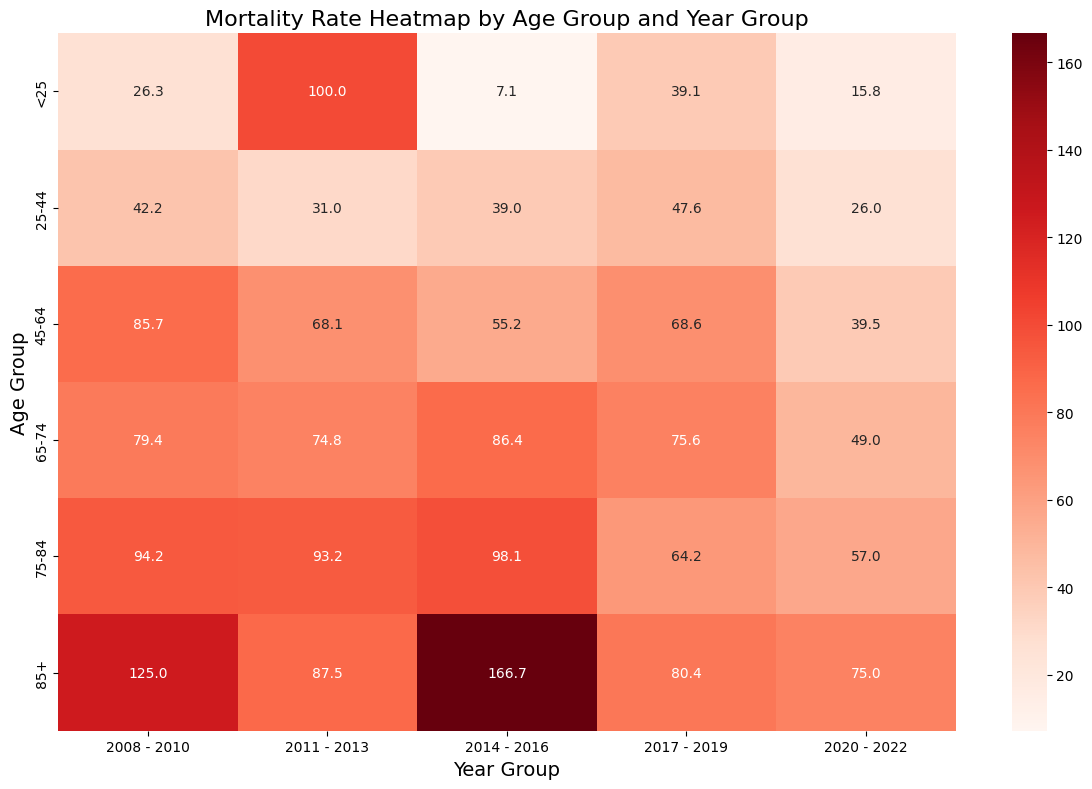

In [30]:
# Calculate mortality rate by age group and year group
heatmap_data = covid_diagnoses.groupby(['anchor_year_group', 'age_group']).agg(
    total_patients=('subject_id', 'nunique'),
    deaths=('is_dead', 'sum')
)
heatmap_data['mortality_rate'] = heatmap_data['deaths'] / heatmap_data['total_patients'] * 100

# Pivot the data for the heatmap
heatmap_pivot = heatmap_data.reset_index().pivot(
    index='age_group',
    columns='anchor_year_group',
    values='mortality_rate'
)

# Sorting indices and columns
heatmap_pivot = heatmap_pivot.sort_index()
heatmap_pivot = heatmap_pivot[sorted(heatmap_pivot.columns, key=lambda x: int(x.split(' - ')[0]))]

# Plotting
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_pivot, annot=True, fmt=".1f", cmap='Reds')
plt.title('Mortality Rate Heatmap by Age Group and Year Group', fontsize=16)
plt.xlabel('Year Group', fontsize=14)
plt.ylabel('Age Group', fontsize=14)
plt.tight_layout()
plt.show()

/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_1828/1436473776.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  insurance_counts = covid_diagnoses.groupby('insurance').size().sort_values(ascending=False)


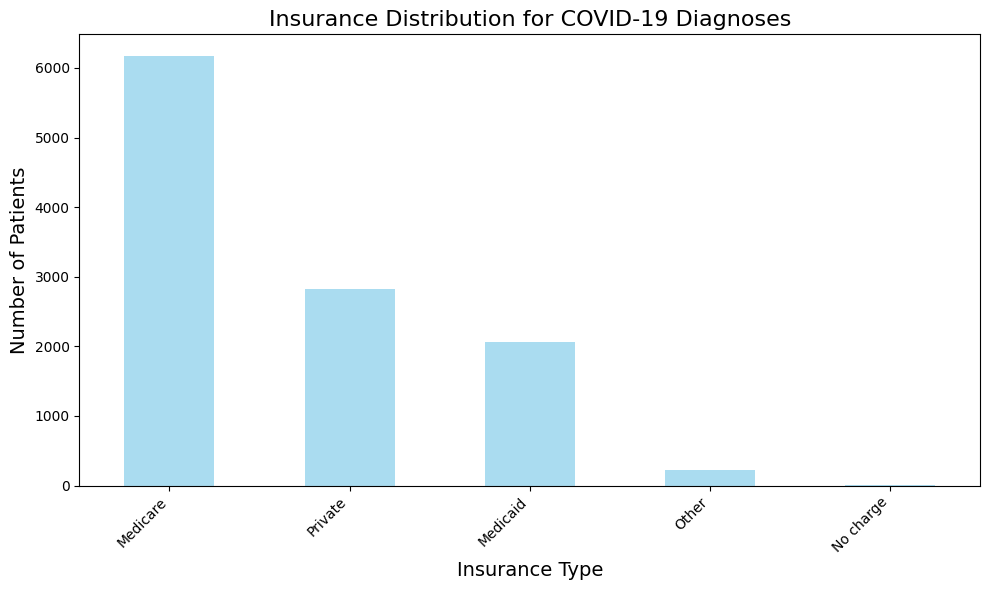

In [31]:
insurance_counts = covid_diagnoses.groupby('insurance').size().sort_values(ascending=False)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
insurance_counts.plot(kind='bar', ax=ax, color='skyblue', alpha=0.7)

# Title and labels
ax.set_title('Insurance Distribution for COVID-19 Diagnoses', fontsize=16)
ax.set_xlabel('Insurance Type', fontsize=14)
ax.set_ylabel('Number of Patients', fontsize=14)

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_1828/1306561847.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_diagnoses['age_group'] = pd.cut(covid_diagnoses['anchor_age'],


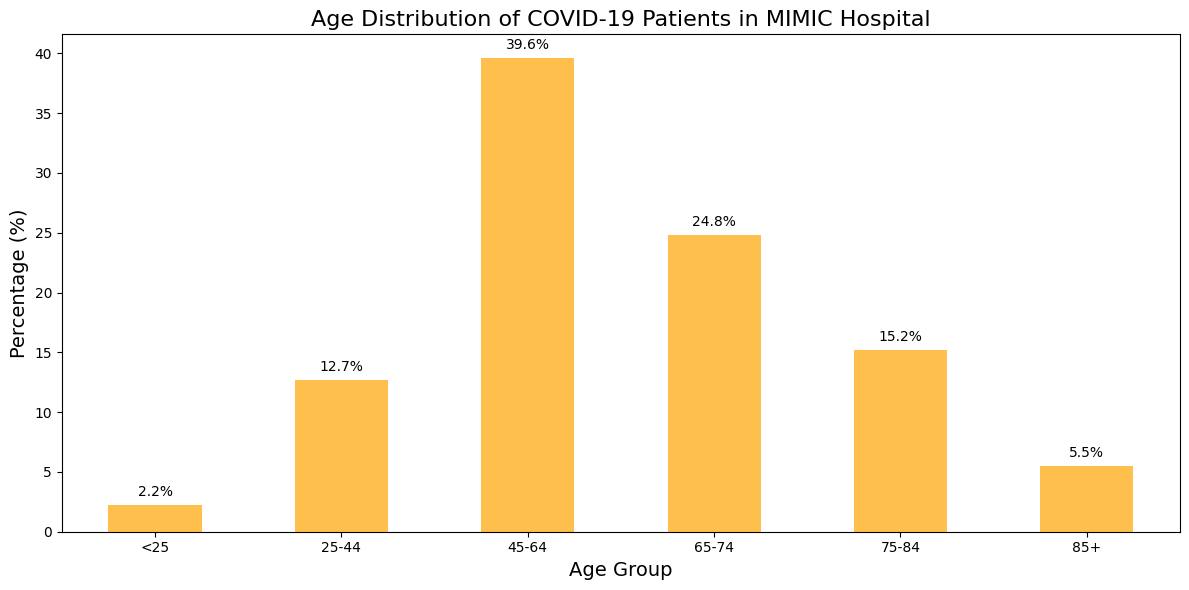

age_group
<25       2.195856
25-44    12.697007
45-64    39.605100
65-74    24.783071
75-84    15.202763
85+       5.516203
Name: proportion, dtype: float64


In [32]:
# Create age groups for COVID-19 patients
covid_diagnoses['age_group'] = pd.cut(covid_diagnoses['anchor_age'], 
                                      bins=[0, 25, 45, 65, 75, 85, 100],
                                      labels=['<25', '25-44', '45-64', '65-74', '75-84', '85+'])

# Calculate the percentage distribution
age_distribution = covid_diagnoses['age_group'].value_counts(normalize=True).sort_index() * 100

# Plotting
plt.figure(figsize=(12, 6))
age_distribution.plot(kind='bar', color='orange', alpha=0.7)

plt.title('Age Distribution of COVID-19 Patients in MIMIC Hospital', fontsize=16)
plt.xlabel('Age Group', fontsize=14)
plt.ylabel('Percentage (%)', fontsize=14)
plt.xticks(rotation=0)

# Add percentage labels on top of each bar
for i, v in enumerate(age_distribution):
    plt.text(i, v + 0.5, f'{v:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print the distribution
print(age_distribution)

/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_1828/1433586836.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  non_covid_diagnoses = diagnosis_icu_df[~diagnosis_icu_df['icd_code'].str.contains(covid_pattern, regex=True, na=False)]
/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_1828/1433586836.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_covid_diagnoses['age_group'] = pd.cut(non_covid_diagnoses['anchor_age'],


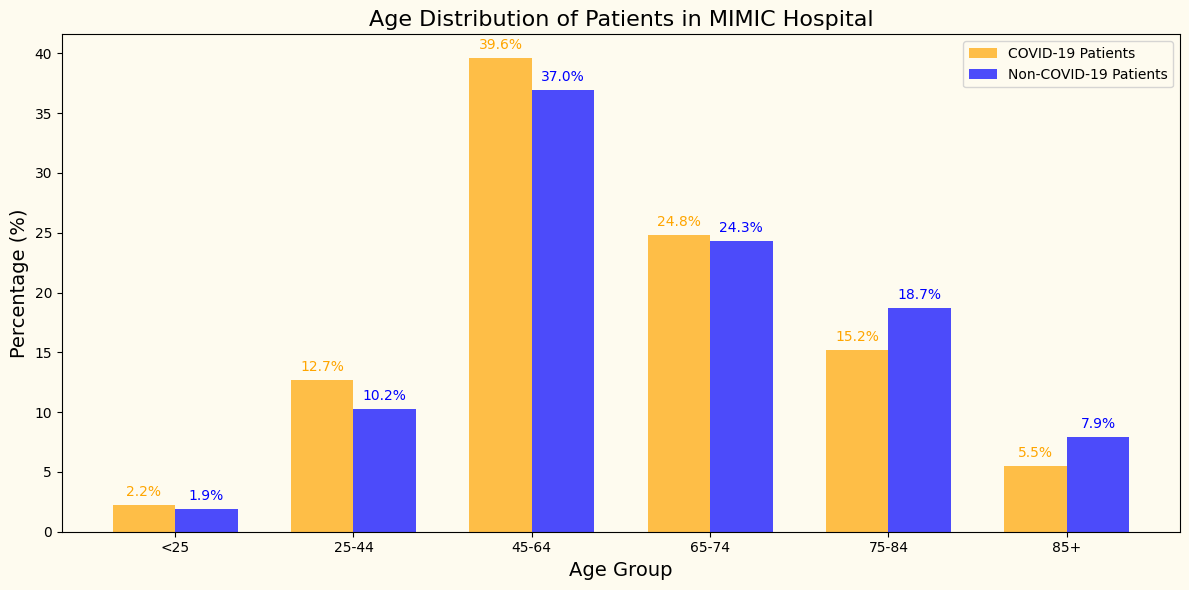

COVID-19 Patients Age Distribution:
age_group
<25       2.195856
25-44    12.697007
45-64    39.605100
65-74    24.783071
75-84    15.202763
85+       5.516203
Name: proportion, dtype: float64

Non-COVID-19 Patients Age Distribution:
age_group
<25       1.897482
25-44    10.243783
45-64    36.967004
65-74    24.318858
75-84    18.690545
85+       7.882328
Name: proportion, dtype: float64


In [33]:
# Create age groups for non-COVID-19 patients
non_covid_diagnoses = diagnosis_icu_df[~diagnosis_icu_df['icd_code'].str.contains(covid_pattern, regex=True, na=False)]
non_covid_diagnoses['age_group'] = pd.cut(non_covid_diagnoses['anchor_age'], 
                                          bins=[0, 25, 45, 65, 75, 85, 100],
                                          labels=['<25', '25-44', '45-64', '65-74', '75-84', '85+'])

# Calculate the percentage distribution for non-COVID-19 patients
non_covid_age_distribution = non_covid_diagnoses['age_group'].value_counts(normalize=True).sort_index() * 100

# Plotting
plt.figure(figsize=(12, 6), facecolor='#fefbef')
plt.rcParams['axes.facecolor'] = '#fefbef'  # Set background color
bar_width = 0.35
index = np.arange(len(age_distribution))

# Plot COVID-19 patients
plt.bar(index, age_distribution, bar_width, label='COVID-19 Patients', color='orange', alpha=0.7)

# Plot non-COVID-19 patients
plt.bar(index + bar_width, non_covid_age_distribution, bar_width, label='Non-COVID-19 Patients', color='blue', alpha=0.7)

plt.title('Age Distribution of Patients in MIMIC Hospital', fontsize=16)
plt.xlabel('Age Group', fontsize=14)
plt.ylabel('Percentage (%)', fontsize=14)
plt.xticks(index + bar_width / 2, age_distribution.index, rotation=0)
plt.legend()

# Add percentage labels on top of each bar
for i, v in enumerate(age_distribution):
    plt.text(i, v + 0.5, f'{v:.1f}%', ha='center', va='bottom', color='orange')
for i, v in enumerate(non_covid_age_distribution):
    plt.text(i + bar_width, v + 0.5, f'{v:.1f}%', ha='center', va='bottom', color='blue')

plt.tight_layout()
plt.show()

# Print the distributions
print("COVID-19 Patients Age Distribution:")
print(age_distribution)
print("\nNon-COVID-19 Patients Age Distribution:")
print(non_covid_age_distribution)

/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_1828/836494164.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  non_covid_diagnoses = diagnosis_icu_df[~diagnosis_icu_df['icd_code'].str.contains(covid_pattern, regex=True, na=False)]
/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_1828/836494164.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  covid_counts = covid_diagnoses.groupby('anchor_year_group')['subject_id'].nunique().reset_index()
/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_1828/836494164.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or 

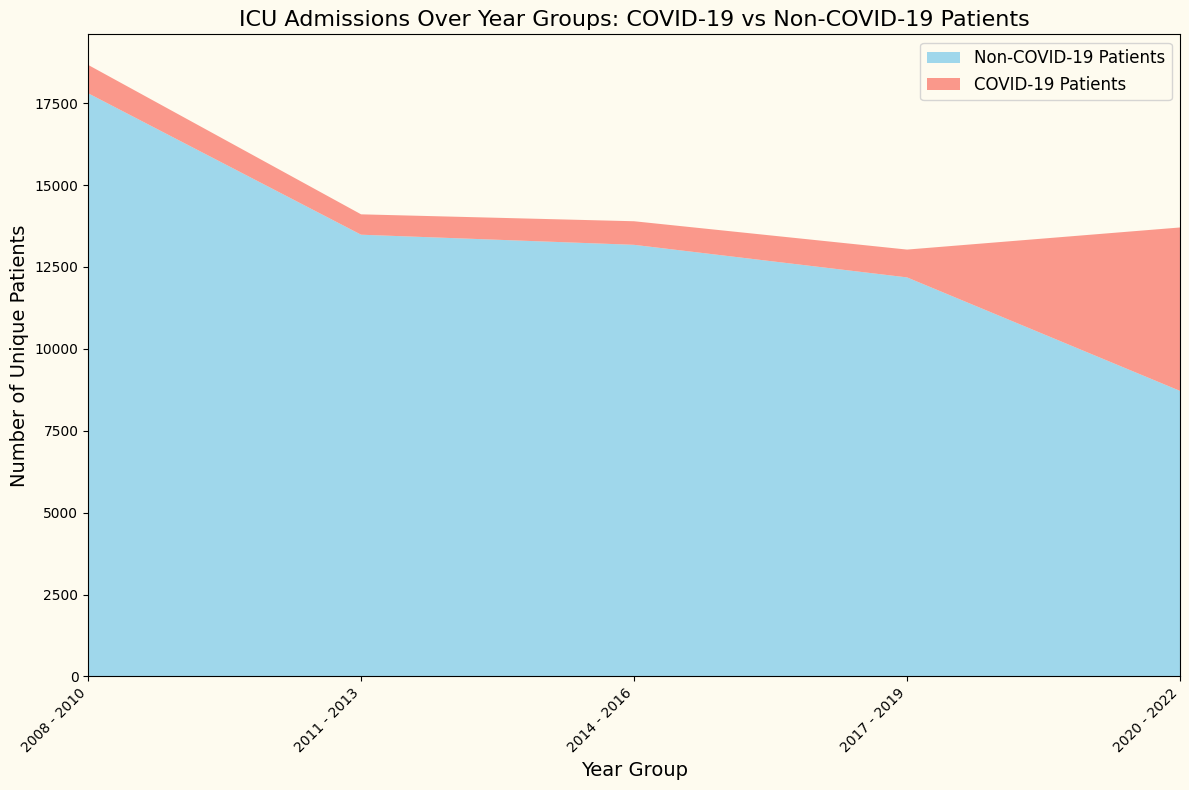

In [41]:
# Define COVID pattern
covid_codes = ['U071', 'U072', 'B9729', 'Z20828', 'Z20822', 'J1289', 'J208', 'J40', 'J22', 'J988', 'J80']
covid_pattern = '^(' + '|'.join(covid_codes) + ')'

# Identify non-COVID-19 ICU patients
non_covid_diagnoses = diagnosis_icu_df[~diagnosis_icu_df['icd_code'].str.contains(covid_pattern, regex=True, na=False)]

# Group and count unique patients
covid_counts = covid_diagnoses.groupby('anchor_year_group')['subject_id'].nunique().reset_index()
covid_counts.rename(columns={'subject_id': 'covid_patients'}, inplace=True)

non_covid_counts = non_covid_diagnoses.groupby('anchor_year_group')['subject_id'].nunique().reset_index()
non_covid_counts.rename(columns={'subject_id': 'non_covid_patients'}, inplace=True)

# Merge counts
patient_counts = pd.merge(covid_counts, non_covid_counts, on='anchor_year_group', how='outer')
patient_counts['total_patients'] = patient_counts['covid_patients'] + patient_counts['non_covid_patients']

# Sort by year group
patient_counts = patient_counts.sort_values(by='anchor_year_group', key=lambda x: x.str.split(' - ').str[0].astype(int))

def plot_icu_admissions(patient_counts):
    """
    Plots an area chart of ICU admissions over year groups for COVID-19 vs Non-COVID-19 patients.

    Parameters:
    - patient_counts (DataFrame): A DataFrame containing columns 'anchor_year_group', 'non_covid_patients', and 'covid_patients'.
    """
    # Plot the area chart
    plt.figure(figsize=(12, 8), facecolor='#fefbef')

    plt.stackplot(
        patient_counts['anchor_year_group'],
        patient_counts['non_covid_patients'],
        patient_counts['covid_patients'],
        labels=['Non-COVID-19 Patients', 'COVID-19 Patients'],
        colors=['skyblue', 'salmon'],
        alpha=0.8
    )

    # removing the margins on the x-axis
    plt.margins(x=0)

    # Titles and labels
    plt.title('ICU Admissions Over Year Groups: COVID-19 vs Non-COVID-19 Patients', fontsize=16)
    plt.xlabel('Year Group', fontsize=14)
    plt.ylabel('Number of Unique Patients', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.legend(loc='upper right', fontsize=12)
    plt.tight_layout()
    plt.show()

plot_icu_admissions(patient_counts)

/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_1828/422150771.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  non_covid_diagnoses = diagnosis_icu_df[~diagnosis_icu_df['icd_code'].str.contains(covid_pattern, regex=True, na=False)]
/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_1828/422150771.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  covid_counts = covid_diagnoses.groupby('anchor_year_group')['subject_id'].nunique().reset_index()
/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_1828/422150771.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or 

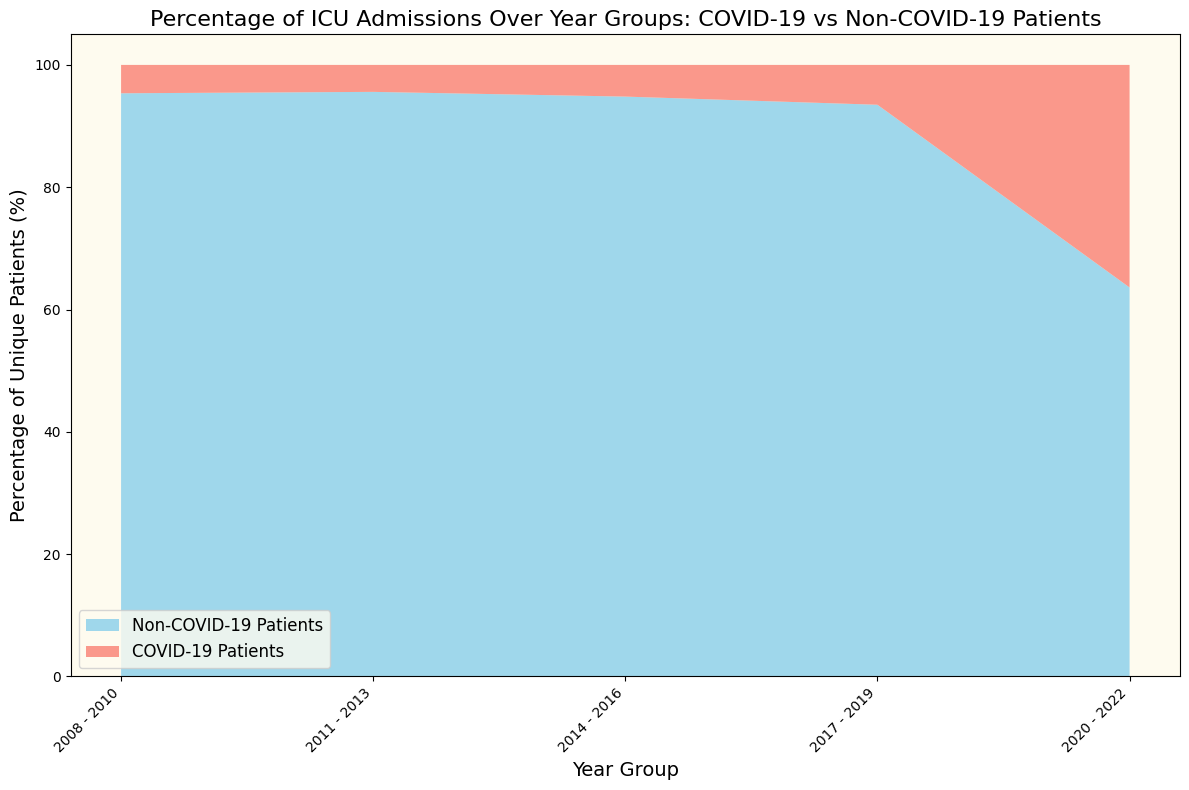

In [37]:
# Define COVID pattern
covid_codes = ['U071', 'U072', 'B9729', 'Z20828', 'Z20822', 'J1289', 'J208', 'J40', 'J22', 'J988', 'J80']
covid_pattern = '^(' + '|'.join(covid_codes) + ')'

# Identify non-COVID-19 ICU patients
non_covid_diagnoses = diagnosis_icu_df[~diagnosis_icu_df['icd_code'].str.contains(covid_pattern, regex=True, na=False)]

# Group and count unique patients
covid_counts = covid_diagnoses.groupby('anchor_year_group')['subject_id'].nunique().reset_index()
covid_counts.rename(columns={'subject_id': 'covid_patients'}, inplace=True)

non_covid_counts = non_covid_diagnoses.groupby('anchor_year_group')['subject_id'].nunique().reset_index()
non_covid_counts.rename(columns={'subject_id': 'non_covid_patients'}, inplace=True)

# Merge counts
patient_counts = pd.merge(covid_counts, non_covid_counts, on='anchor_year_group', how='outer')

# Fill NaN values with 0
patient_counts[['covid_patients', 'non_covid_patients']] = patient_counts[['covid_patients', 'non_covid_patients']]

# Calculate total patients
patient_counts['total_patients'] = patient_counts['covid_patients'] + patient_counts['non_covid_patients']

# Calculate percentages
patient_counts['covid_pct'] = (patient_counts['covid_patients'] / patient_counts['total_patients']) * 100
patient_counts['non_covid_pct'] = (patient_counts['non_covid_patients'] / patient_counts['total_patients']) * 100

# Sort by year group
patient_counts = patient_counts.sort_values(by='anchor_year_group', key=lambda x: x.str.split(' - ').str[0].astype(int))

# Plot the normalized area chart
plt.figure(figsize=(12, 8))

plt.stackplot(
    patient_counts['anchor_year_group'],
    patient_counts['non_covid_pct'],
    patient_counts['covid_pct'],
    labels=['Non-COVID-19 Patients', 'COVID-19 Patients'],
    colors=['skyblue', 'salmon'],
    alpha=0.8
)

# Titles and labels
plt.title('Percentage of ICU Admissions Over Year Groups: COVID-19 vs Non-COVID-19 Patients', fontsize=16)
plt.xlabel('Year Group', fontsize=14)
plt.ylabel('Percentage of Unique Patients (%)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(loc='lower left', fontsize=12)
plt.tight_layout()
plt.show()

## Importing Insurance Data 

In [15]:
# load suffolk_df

import pickle

suffolk_df = pickle.load(open("../Processed_Data/suffolk_df.pkl", "rb"))

/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_76567/4259004.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_diagnoses['age_group'] = pd.cut(covid_diagnoses['anchor_age'], bins=bins, labels=age_labels, right=False)


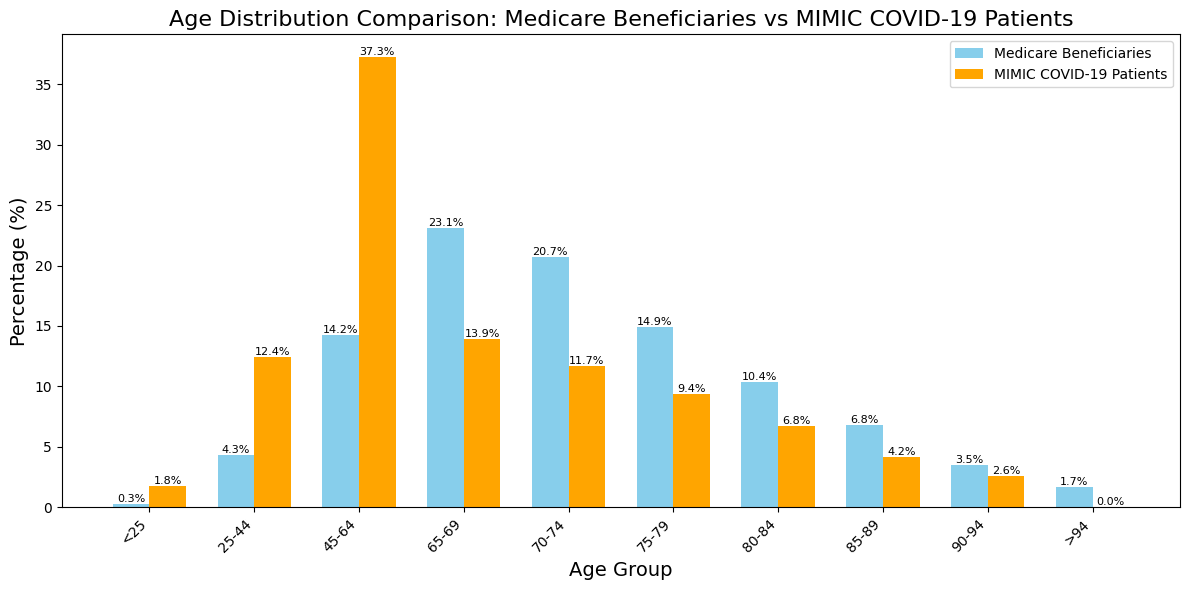

Medicare Beneficiaries Age Distribution:
<25       0.28
25-44     4.29
45-64    14.24
65-69    23.08
70-74    20.71
75-79    14.95
80-84    10.39
85-89     6.85
90-94     3.53
>94       1.67
dtype: float64

MIMIC Hospital COVID-19 Patients Age Distribution:
age_group
<25       1.80
25-44    12.42
45-64    37.26
65-69    13.93
70-74    11.66
75-79     9.39
80-84     6.76
85-89     4.18
90-94     2.60
>94       0.00
Name: count, dtype: float64


In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming suffolk_df is already loaded and covid_diagnoses is available

# Age Distribution Analysis for Medicare Beneficiaries
age_columns = [
    'AGE_LT_25_BENES', 'AGE_25_TO_44_BENES', 'AGE_45_TO_64_BENES',
    'AGE_65_TO_69_BENES', 'AGE_70_TO_74_BENES', 'AGE_75_TO_79_BENES',
    'AGE_80_TO_84_BENES', 'AGE_85_TO_89_BENES', 'AGE_90_TO_94_BENES',
    'AGE_GT_94_BENES'
]

age_distribution_medicare = suffolk_df[age_columns].sum()
total_beneficiaries = age_distribution_medicare.sum()
age_percentages_medicare = (age_distribution_medicare / total_beneficiaries * 100).round(2)

# Friendly labels for visualization
age_labels = [
    '<25', '25-44', '45-64', '65-69', '70-74', '75-79',
    '80-84', '85-89', '90-94', '>94'
]

age_percentages_medicare.index = age_labels

# For COVID-19 patients (assuming covid_diagnoses DataFrame exists)
bins = [0, 25, 45, 65, 70, 75, 80, 85, 90, 95, 150]
covid_diagnoses['age_group'] = pd.cut(covid_diagnoses['anchor_age'], bins=bins, labels=age_labels, right=False)

age_distribution_covid = covid_diagnoses['age_group'].value_counts().sort_index()
total_covid_patients = age_distribution_covid.sum()
age_percentages_covid = (age_distribution_covid / total_covid_patients * 100).round(2)

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

x = range(len(age_labels))
width = 0.35

ax.bar([i - width/2 for i in x], age_percentages_medicare, width, label='Medicare Beneficiaries', color='skyblue')
ax.bar([i + width/2 for i in x], age_percentages_covid, width, label='MIMIC COVID-19 Patients', color='orange')

ax.set_ylabel('Percentage (%)', fontsize=14)
ax.set_xlabel('Age Group', fontsize=14)
ax.set_title('Age Distribution Comparison: Medicare Beneficiaries vs MIMIC COVID-19 Patients', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(age_labels, rotation=45, ha='right')
ax.legend()

# Add percentage labels on top of each bar
for i, v in enumerate(age_percentages_medicare):
    ax.text(i - width/2, v, f'{v:.1f}%', ha='center', va='bottom', fontsize=8)
for i, v in enumerate(age_percentages_covid):
    ax.text(i + width/2, v, f'{v:.1f}%', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# Print the distributions
print("Medicare Beneficiaries Age Distribution:")
print(age_percentages_medicare)
print("\nMIMIC Hospital COVID-19 Patients Age Distribution:")
print(age_percentages_covid)

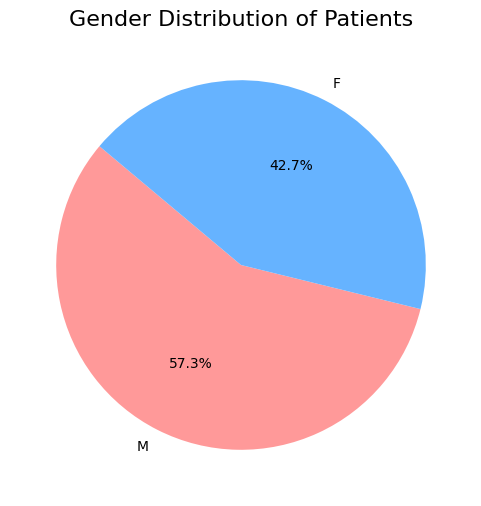

In [46]:
# Pie chart of gender distribution
gender_counts = covid_diagnoses['gender'].value_counts()
plt.figure(figsize=(6, 6))
gender_counts.plot.pie(autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff'])
plt.title('Gender Distribution of Patients', fontsize=16)
plt.ylabel('')
plt.show()

/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_1828/699991487.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_diagnoses['age_group'] = pd.cut(covid_diagnoses['anchor_age'], bins=age_bins, labels=age_labels)
/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_1828/699991487.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mortality_by_age = covid_diagnoses.groupby('age_group')['is_dead'].mean().reset_index()
/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_1828/699991487.py:11: FutureWarning: 

Passing `palette` witho

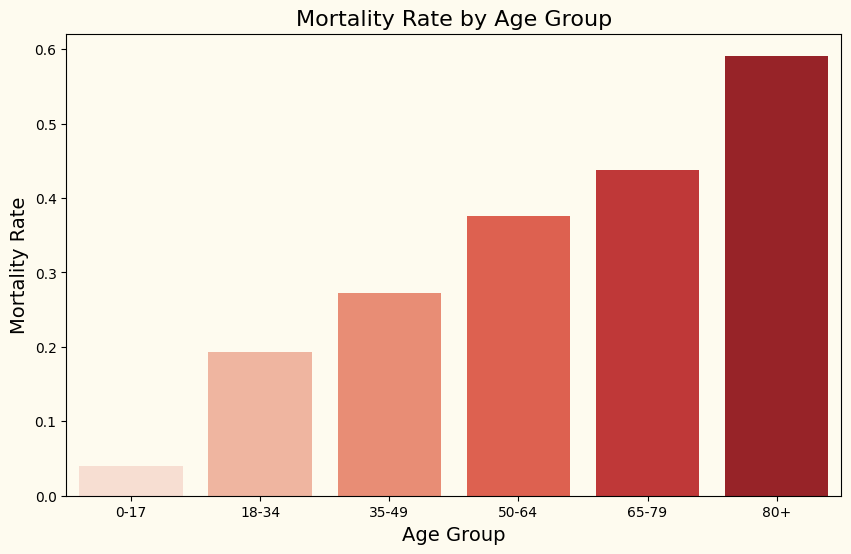

In [51]:
# Create age bins
age_bins = [0, 18, 35, 50, 65, 80, 100]
age_labels = ['0-17', '18-34', '35-49', '50-64', '65-79', '80+']
covid_diagnoses['age_group'] = pd.cut(covid_diagnoses['anchor_age'], bins=age_bins, labels=age_labels)

# Calculate mortality rates
mortality_by_age = covid_diagnoses.groupby('age_group')['is_dead'].mean().reset_index()

# Bar plot of mortality rates by age group
plt.figure(figsize=(10, 6), facecolor='#fefbef')
sns.barplot(data=mortality_by_age, x='age_group', y='is_dead', palette='Reds')
plt.title('Mortality Rate by Age Group', fontsize=16)
plt.xlabel('Age Group', fontsize=14)
plt.ylabel('Mortality Rate', fontsize=14)
plt.show()

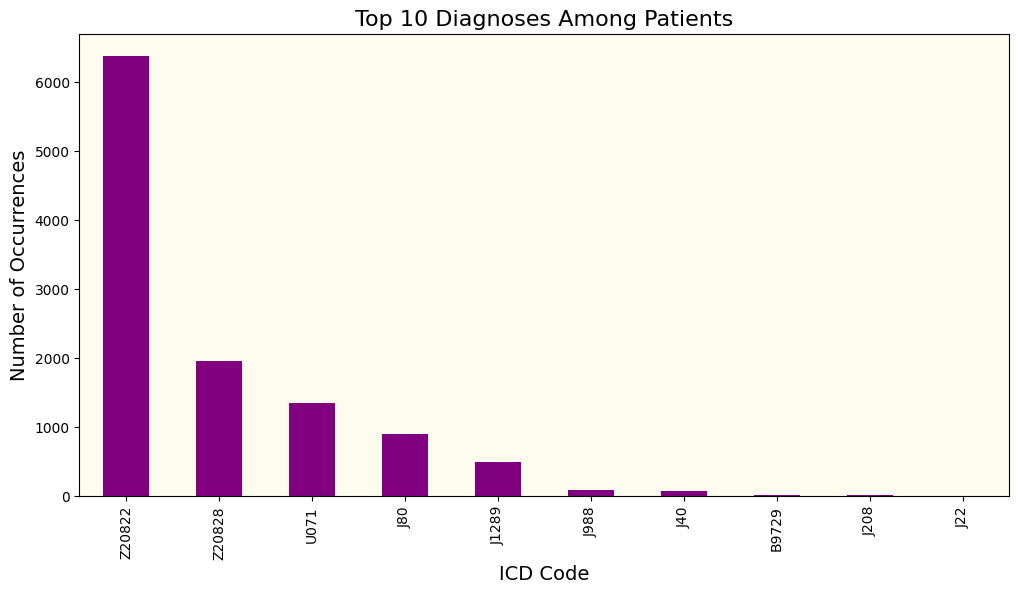

In [50]:

# Count of diagnoses
top_diagnoses = covid_diagnoses['icd_code'].value_counts().nlargest(10)

# Bar plot of top diagnoses
plt.figure(figsize=(12, 6))
top_diagnoses.plot(kind='bar', color='purple')
plt.title('Top 10 Diagnoses Among Patients', fontsize=16)
plt.xlabel('ICD Code', fontsize=14)
plt.ylabel('Number of Occurrences', fontsize=14)
plt.show()

## Exploring Prescriptions In Covid 

In [17]:
prescriptions_table = pd.read_csv(FILE_PATHS['prescriptions'],
                                  usecols=['subject_id', 'hadm_id', 'drug_type', 'drug', 'gsn', 'ndc', 'prod_strength'],)

# convert cols to category
cat_cols = ['drug_type', 'drug']
for col in cat_cols:
    prescriptions_table[col] = prescriptions_table[col].astype('category')

prescriptions_table

/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_76567/1695585596.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  prescriptions_table = pd.read_csv(FILE_PATHS['prescriptions'],


,subject_id,hadm_id,drug_type,drug,gsn,ndc,prod_strength
0,10000032,22595853,MAIN,Furosemide,008209,5.107901e+10,40mg Tablet
1,10000032,22595853,MAIN,Ipratropium Bromide Neb,021700,4.879801e+08,2.5mL Vial
2,10000032,22595853,MAIN,Furosemide,008208,5.107901e+10,20mg Tablet
3,10000032,22595853,MAIN,Potassium Chloride,001275,2.450041e+08,10mEq ER Tablet
4,10000032,22595853,MAIN,Sodium Chloride 0.9% Flush,NaN,0.000000e+00,10 mL Syringe
...,...,...,...,...,...,...,...
20292606,19999987,23865745,MAIN,Propofol,65888.0,6.332303e+10,1000mg/100mL Vial
20292607,19999987,23865745,BASE,0.9% Sodium Chloride,1210.0,3.380049e+08,100mL Bag
20292608,19999987,23865745,MAIN,LeVETiracetam,61005.0,1.478904e+10,500mg/5mL Vial
20292609,19999987,23865745,MAIN,Acetaminophen,4489.0,5.107900e+10,325mg Tablet


In [18]:
prescriptions_table.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20292611 entries, 0 to 20292610
Data columns (total 7 columns):
 #   Column         Dtype   
---  ------         -----   
 0   subject_id     int64   
 1   hadm_id        int64   
 2   drug_type      category
 3   drug           category
 4   gsn            object  
 5   ndc            float64 
 6   prod_strength  object  
dtypes: category(2), float64(1), int64(2), object(2)
memory usage: 832.5+ MB


In [19]:
Utils.print_info(prescriptions_table)


DataFrame Information for: Unnamed DataFrame

Shape:
  Rows: 20292611, Columns: 7

Column Types:
  int64: 2
  object: 2
  category: 1
  category: 1
  float64: 1

Missing Values:
  drug: 1 (0.00%)
  gsn: 2407028 (11.86%)
  ndc: 33456 (0.16%)
  prod_strength: 9398 (0.05%)

Numeric Columns Summary:
         subject_id       hadm_id           ndc
count  2.029261e+07  2.029261e+07  2.025916e+07
mean   1.500704e+07  2.500108e+07  1.771826e+10
std    2.883361e+06  2.885402e+06  2.650798e+10
min    1.000003e+07  2.000002e+07  0.000000e+00
25%    1.251397e+07  2.250350e+07  1.725729e+08
50%    1.500679e+07  2.500749e+07  4.879801e+08
75%    1.751464e+07  2.749326e+07  5.026806e+10
max    1.999999e+07  2.999993e+07  9.920702e+10

Categorical Columns Summary:
  drug_type:
    Unique values: 3
    Top 5 values: {'MAIN': 16791812, 'BASE': 3471112, 'ADDITIVE': 29687}
  drug:
    Unique values: 10926
    Top 5 values: {'Insulin': 845166, '0.9% Sodium Chloride': 728089, 'Potassium Chloride': 674552, 

,subject_id,hadm_id,drug_type,drug,gsn,ndc,prod_strength
0,10000032,22595853,MAIN,Furosemide,008209,5.107901e+10,40mg Tablet
1,10000032,22595853,MAIN,Ipratropium Bromide Neb,021700,4.879801e+08,2.5mL Vial
2,10000032,22595853,MAIN,Furosemide,008208,5.107901e+10,20mg Tablet
3,10000032,22595853,MAIN,Potassium Chloride,001275,2.450041e+08,10mEq ER Tablet
4,10000032,22595853,MAIN,Sodium Chloride 0.9% Flush,NaN,0.000000e+00,10 mL Syringe


In [27]:
diagnosis_icu_df.shape
#icu_prescriptions = diagnosis_icu_df.merge(prescriptions_table, on=['subject_id', 'hadm_id'], how='inner')

(1759242, 33)

In [21]:
# merge with covid_diagnosis population
covid_prescriptions = covid_diagnoses.merge(prescriptions_table, on=['subject_id', 'hadm_id'], how='inner')
covid_prescriptions.head()

,subject_id,hadm_id,icd_code,icd_version,category_code,category,subcategory,stay_id,first_careunit,last_careunit,...,edouttime,hospital_expire_flag,admission_los_hours,covid_category,age_group,drug_type,drug,gsn,ndc,prod_strength
0,10002114,27793700,Z20822,10,Z20,Health Factors & Services,Persons with potential health hazards related ...,34672098,Coronary Care Unit (CCU),Coronary Care Unit (CCU),...,2162-02-17 23:30:00,0,352.733333,Suspected,45-64,BASE,Iso-Osmotic Sodium Chloride,NaN,0.000000e+00,100mL Bag
1,10002114,27793700,Z20822,10,Z20,Health Factors & Services,Persons with potential health hazards related ...,34672098,Coronary Care Unit (CCU),Coronary Care Unit (CCU),...,2162-02-17 23:30:00,0,352.733333,Suspected,45-64,MAIN,Calcium Gluconate,079278,4.456706e+10,2 g / 100 mL Premix Bag
2,10002114,27793700,Z20822,10,Z20,Health Factors & Services,Persons with potential health hazards related ...,34672098,Coronary Care Unit (CCU),Coronary Care Unit (CCU),...,2162-02-17 23:30:00,0,352.733333,Suspected,45-64,MAIN,Heparin,006549,2.502104e+10,5000 Units / mL- 1mL Vial
3,10002114,27793700,Z20822,10,Z20,Health Factors & Services,Persons with potential health hazards related ...,34672098,Coronary Care Unit (CCU),Coronary Care Unit (CCU),...,2162-02-17 23:30:00,0,352.733333,Suspected,45-64,MAIN,Furosemide,008208,5.482972e+07,20mg Tablet
4,10002114,27793700,Z20822,10,Z20,Health Factors & Services,Persons with potential health hazards related ...,34672098,Coronary Care Unit (CCU),Coronary Care Unit (CCU),...,2162-02-17 23:30:00,0,352.733333,Suspected,45-64,MAIN,Thiamine,016981,5.164509e+10,100mg Tablet


In [22]:
covid_prescriptions.anchor_year_group.unique()

['2020 - 2022', '2014 - 2016', '2008 - 2010', '2017 - 2019', '2011 - 2013']
Categories (5, object): ['2008 - 2010', '2011 - 2013', '2014 - 2016', '2017 - 2019', '2020 - 2022']

<Axes: xlabel='drug'>

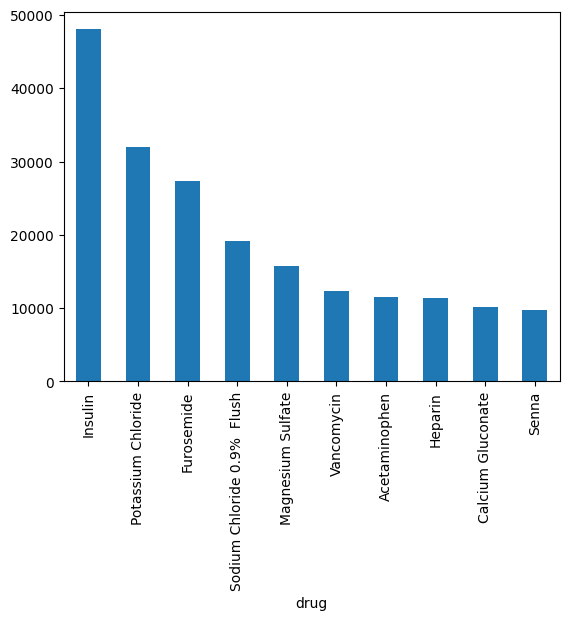

In [23]:
covid_prescriptions.query("drug_type == 'MAIN' & anchor_year_group != '2020 - 2022'").drug.value_counts().head(10).plot.bar()

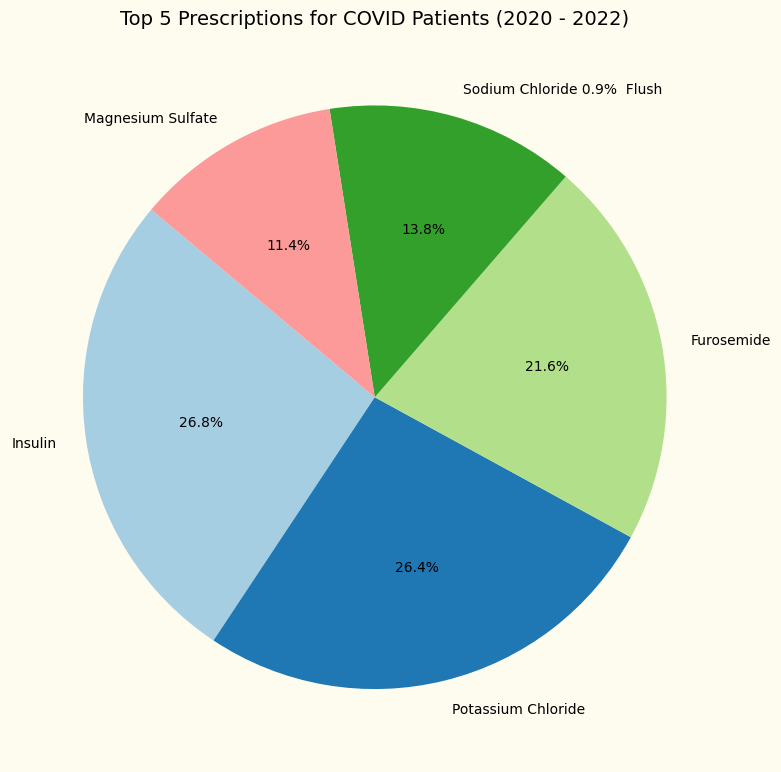

In [64]:
top5_drugs = covid_prescriptions.query("drug_type == 'MAIN' & anchor_year_group == '2020 - 2022'")['drug'].value_counts().head(5)

plt.figure(figsize=(8, 8), facecolor='#fefbef')
top5_drugs.plot.pie(autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Top 5 Prescriptions for COVID Patients (2020 - 2022)', fontsize=14)
plt.ylabel('')
plt.tight_layout()
plt.show()

Antiviral Medications
Paxlovid (nirmatrelvir/ritonavir)
NDC: 00069108506
NDC: 00069108530
NDC: 00069110120
NDC: 00069110104
NDC: 00069034530
NDC: 00069034506
Remdesivir (Veklury)
No specific NDC provided in the search results
Molnupiravir (Lagevrio)
NDC: 00006505506
NDC: 00006505507

In [25]:
# Define the NDC codes we're looking for
ndc_codes = [
    '00069108506', '00069108530', '00069110120', '00069110104', 
    '00069034530', '00069034506', '00006505506', '00006505507'
]

# Convert NDC codes to the same format as in the DataFrame (assuming they're stored as floats)
ndc_codes_float = [float(code) for code in ndc_codes]

# Filter the DataFrame for matching NDC codes
covid_antiviral_prescriptions = covid_prescriptions[covid_prescriptions['ndc'].isin(ndc_codes_float)]

# Display the results
print(f"Found {len(covid_antiviral_prescriptions)} prescriptions matching the specified NDC codes.")
print(covid_antiviral_prescriptions[['subject_id', 'hadm_id', 'drug', 'ndc', 'prod_strength']])

# Count occurrences of each drug
drug_counts = covid_antiviral_prescriptions['drug'].value_counts()
print("\nDrug counts:")
print(drug_counts)

# Check for Remdesivir by drug name (since NDC wasn't provided)
remdesivir_prescriptions = covid_prescriptions[covid_prescriptions['drug'].str.contains('Remdesivir', case=False, na=False)]
print(f"\nFound {len(remdesivir_prescriptions)} prescriptions for Remdesivir.")
print(remdesivir_prescriptions[['subject_id', 'hadm_id', 'drug', 'ndc', 'prod_strength']])

Found 18 prescriptions matching the specified NDC codes.
         subject_id   hadm_id                          drug         ndc  \
198765     11064975  21841886  Nirmatrelvir-Ritonavir (EUA)  69108530.0   
198791     11064975  21841886  Nirmatrelvir-Ritonavir (EUA)  69108530.0   
198926     11064975  21841886  Nirmatrelvir-Ritonavir (EUA)  69108530.0   
215849     11168241  21430249  Nirmatrelvir-Ritonavir (EUA)  69108530.0   
946830     15168081  22611123  Nirmatrelvir-Ritonavir (EUA)  69108530.0   
983193     15352109  23759831  Nirmatrelvir-Ritonavir (EUA)  69108530.0   
1144661    16179209  29791511  Nirmatrelvir-Ritonavir (EUA)  69108530.0   
1418539    17713219  23018295  Nirmatrelvir-Ritonavir (EUA)  69108530.0   
1418555    17713219  23018295  Nirmatrelvir-Ritonavir (EUA)  69108530.0   
1418556    17713219  23018295  Nirmatrelvir-Ritonavir (EUA)  69108530.0   
1418581    17713219  23018295  Nirmatrelvir-Ritonavir (EUA)  69108530.0   
1418598    17713219  23018295  Nirmatrelvir

/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_76567/1913276948.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_prescriptions = all_antiviral_prescriptions.groupby('anchor_year_group').size().sort_index()


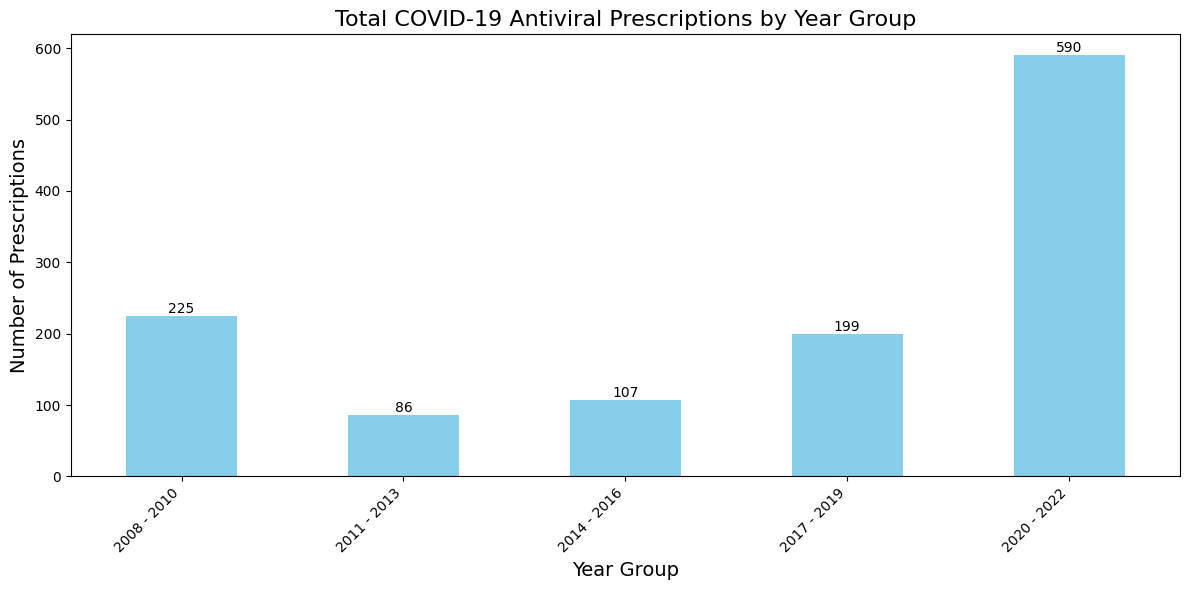

Total prescriptions by year group:
anchor_year_group
2008 - 2010    225
2011 - 2013     86
2014 - 2016    107
2017 - 2019    199
2020 - 2022    590
dtype: int64


In [30]:
# Combine antiviral prescriptions
all_antiviral_prescriptions = pd.concat([covid_antiviral_prescriptions, remdesivir_prescriptions])

# Group by anchor_year_group and count total prescriptions
total_prescriptions = all_antiviral_prescriptions.groupby('anchor_year_group').size().sort_index()

# Create a bar chart
plt.figure(figsize=(12, 6))
ax = total_prescriptions.plot(kind='bar', color='skyblue')

plt.title('Total COVID-19 Antiviral Prescriptions by Year Group', fontsize=16)
plt.xlabel('Year Group', fontsize=14)
plt.ylabel('Number of Prescriptions', fontsize=14)
plt.xticks(rotation=45, ha='right')

# Add value labels on the bars
for i, v in enumerate(total_prescriptions):
    ax.text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print the data
print("Total prescriptions by year group:")
print(total_prescriptions)